In [1683]:
!pip install statsmodels
# test


[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [1684]:
!pip install pandas openpyxl


[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [1685]:
!pip install geopandas


[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [1686]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib
import seaborn
import matplotlib.pyplot as plt
from scipy.stats import iqr
from scipy.stats import median_test


## Import population info from census

In [1687]:
#import Pop_County
df_census2020 = pd.read_csv('DECENNIALPL2020.P1-2024-11-10T174624.csv')
df_population_bycounty = df_census2020.head(1)
df_population_bycounty.columns = df_population_bycounty.columns.str.replace(' County, California', '', regex=False)
county_names = df_population_bycounty.columns[1:]
populations = df_population_bycounty.iloc[0, 1:].replace(',', '', regex=True).astype(int)
df_population_bycounty = pd.DataFrame({
    'County': county_names,
    'Population': populations
}).reset_index(drop=True)
df_population_bycounty = df_population_bycounty.rename(columns={'County': 'CountyName'})
print(len(df_population_bycounty))
df_population_bycounty.head()
# county_names


58


,CountyName,Population
0,Alameda,1682353
1,Alpine,1204
2,Amador,40474
3,Butte,211632
4,Calaveras,45292


## Import hospital data

In [1688]:
# import hospital data

# df_hospital = pd.read_csv('ed-volume-and-capacity-2021.csv', encoding = "ISO-8859-1", index_col=[0])
# df_hospital = df_hospital[df_hospital["Category"] == "Asthma"]
# df_hospital_bycounty = df_hospital.groupby('CountyName')['EDDXCount'].sum().reset_index()
# df_hospital_bycounty.head()

df_hospital = pd.read_csv('asthma-emergency-department-visit-rates-by-county-2015_2022.csv', encoding = "ISO-8859-1")
df_hospital_bycounty = df_hospital[df_hospital["STRATA NAME"] == "All ages"]
df_hospital_bycounty = df_hospital_bycounty[df_hospital_bycounty["YEAR"] <= 2019]
df_hospital_bycounty = df_hospital_bycounty.rename(columns={'COUNTY': 'CountyName'})
df_hospital_bycounty = df_hospital_bycounty[["CountyName", "YEAR", "AGE-ADJUSTED ED VISIT RATE"]]
df_hospital_bycounty = df_hospital_bycounty[df_hospital_bycounty["CountyName"] != "California"]
print(len(df_hospital_bycounty))
df_hospital_bycounty.head()

290


,CountyName,YEAR,AGE-ADJUSTED ED VISIT RATE
1,Alameda,2015,64.3
2,Alpine,2015,0.0
3,Amador,2015,58.4
4,Butte,2015,50.2
5,Calaveras,2015,48.0


In [1689]:
df_hospital_pop_bycounty = pd.merge(df_population_bycounty, df_hospital_bycounty, on='CountyName', how='inner')
df_hospital_pop_bycounty["AGE-ADJUSTED ED VISIT RATE"] = df_hospital_pop_bycounty["AGE-ADJUSTED ED VISIT RATE"].replace({',': ''}, regex=True)
df_hospital_pop_bycounty["AGE-ADJUSTED ED VISIT RATE"] = pd.to_numeric(df_hospital_pop_bycounty["AGE-ADJUSTED ED VISIT RATE"])

df_hospital_pop_bycounty.rename(columns={'AGE-ADJUSTED ED VISIT RATE': 'VisitRate'}, inplace=True)

df_hospital_pop_bycounty = df_hospital_pop_bycounty.dropna()

df_hospital_pop_bycounty['VisitRate'] = (
        df_hospital_pop_bycounty['VisitRate'] - df_hospital_pop_bycounty['VisitRate'].min()
    ) / (df_hospital_pop_bycounty['VisitRate'].max() - df_hospital_pop_bycounty['VisitRate'].min())

# df_hospital_pop_bycounty = df_hospital_pop_bycounty[df_hospital_pop_bycounty['VisitRate'] >= 1] # remove 1 outlier 

print(len(df_hospital_pop_bycounty))
df_hospital_pop_bycounty.head(n=6)

283


,CountyName,Population,YEAR,VisitRate
0,Alameda,1682353,2015,0.588289
1,Alameda,1682353,2016,0.528820
2,Alameda,1682353,2017,0.515096
3,Alameda,1682353,2018,0.444648
4,Alameda,1682353,2019,0.419030
5,Alpine,1204,2015,0.000000


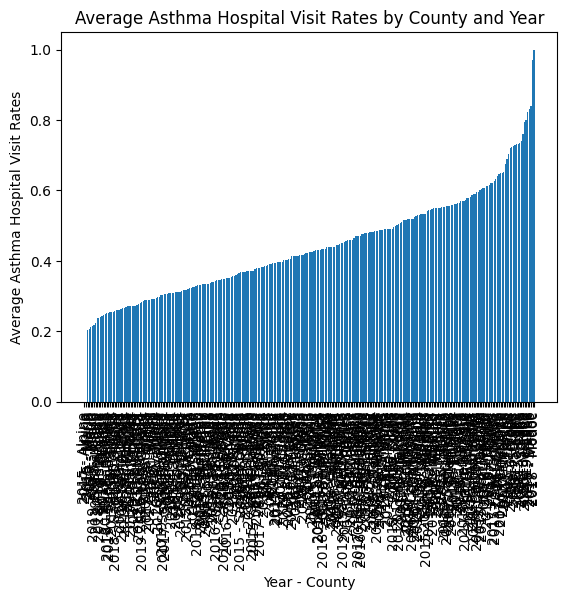

In [1690]:
df_hospital_pop_bycounty['YearCounty'] = df_hospital_pop_bycounty['YEAR'].astype(str) + ' - ' + df_hospital_pop_bycounty['CountyName']
df_hospital_pop_bycounty_sorted = df_hospital_pop_bycounty.sort_values(by='VisitRate', ascending=True)
plt.bar(df_hospital_pop_bycounty_sorted['YearCounty'], df_hospital_pop_bycounty_sorted['VisitRate'])
plt.xticks(rotation=90)
plt.xlabel('Year - County')
plt.ylabel('Average Asthma Hospital Visit Rates')
plt.title('Average Asthma Hospital Visit Rates by County and Year')
plt.show()

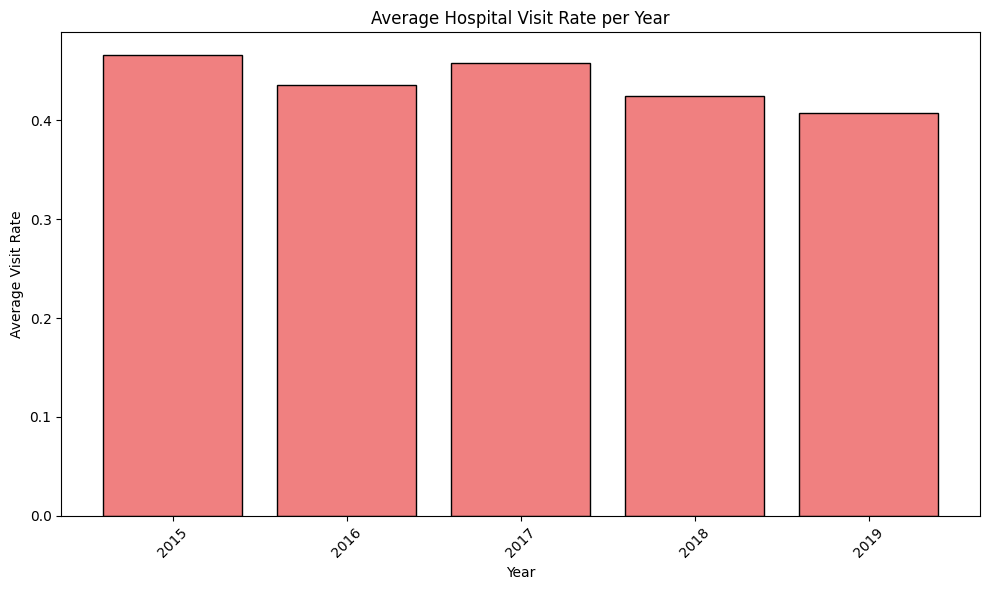

In [1691]:
# Calculate the average VisitRate per year
average_visits_per_year = df_hospital_pop_bycounty.groupby('YEAR')['VisitRate'].mean()

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(average_visits_per_year.index, average_visits_per_year.values, color='lightcoral', edgecolor='black')

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Average Visit Rate')
plt.title('Average Hospital Visit Rate per Year')
plt.xticks(average_visits_per_year.index, rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

In [1692]:
# import matplotlib.pyplot as plt

# df_hospital_pop_bycounty_sorted = df_hospital_pop_bycounty.sort_values(by='NormalizedVisits', ascending=True)

# plt.bar(df_hospital_pop_bycounty_sorted['CountyName'], df_hospital_pop_bycounty_sorted['NormalizedVisits'])
# plt.xticks(range(df_hospital_pop_bycounty_sorted['CountyName'].shape[0]), df_hospital_pop_bycounty_sorted['CountyName'], rotation='vertical')
# plt.xlabel('County')
# plt.ylabel('Average Asthma Hospital Visits')
# plt.title('Average Asthma Hospital Visits by County')
# plt.show()

## Get AQI Data

In [1693]:
# Function to count number of days with aqi at or worse than 100
def make_aqi_df(csv_name, year):
    df_air = pd.read_csv(csv_name, encoding = "ISO-8859-1", index_col=[0])
    df_air = df_air.groupby('County')['Daily AQI Value'].apply(lambda x: (x >= 100).sum()).reset_index()
    df_air = df_air.rename(columns={'Daily AQI Value': 'Weighted AQI Days'})
    df_air['Year'] = year
    return df_air[['County', 'Year', 'Weighted AQI Days']]

In [1694]:
# Function to calculate weighted sum of days with bad aqi
# 0-50: weight 0, 51-100: weight 1, 101-150: weight 2, 151-200 weight 3, 201-300 weight 4, >300: weight 5
def calc_weighted_sum(df):
        class_5 = (df['Daily AQI Value'] > 300).sum()
        class_4 = ((df['Daily AQI Value'] > 200) & (df['Daily AQI Value'] <= 300)).sum()
        class_3 = ((df['Daily AQI Value'] > 150) & (df['Daily AQI Value'] <= 200)).sum()
        class_2 = ((df['Daily AQI Value'] > 100) & (df['Daily AQI Value'] <= 150)).sum()
        class_1 = ((df['Daily AQI Value'] > 50) & (df['Daily AQI Value'] <= 100)).sum()

        weighted_sum = 5 * class_5 + 4 * class_4 + 3 * class_3 + 2 * class_2 + class_1
        return weighted_sum

In [1695]:
# Function to make df with weighted aqi days from single year csv

def make_weighted_aqi_df(csv_name, year):
    df_air_preprocess = pd.read_csv(csv_name, encoding="ISO-8859-1", index_col=[0])
    number_of_sensors = len(df_air_preprocess['Site ID'].unique())
    num_missing_data = (number_of_sensors * 365 ) - len(df_air_preprocess)
    print("Missing ", num_missing_data, " of expected ", number_of_sensors * 365, "data points in year ", year)
    df_air_preprocess = df_air_preprocess[['County', 'Daily AQI Value', 'Site ID']]
    counties = df_air_preprocess['County'].unique()

    # count instances of different aqi values
    counts_df = pd.DataFrame(columns=['County', 'Weighted AQI Days'])
    county_sum = 0
    for county in counties:
        county_df = df_air_preprocess[df_air_preprocess['County'] == county]

        for sensor in county_df['Site ID'].unique():
            sensor_df = county_df[county_df['Site ID'] == sensor]
            sensor_sum = calc_weighted_sum(sensor_df)
            county_sum += sensor_sum / len(sensor_df)

        county_sum = county_sum / len(county_df['Site ID'].unique())

        new_df_row = pd.DataFrame([[county, county_sum]], columns=['County', 'Weighted AQI Days'])
        counts_df = pd.concat([counts_df, new_df_row])

    counts_df['Year'] = year
    return counts_df.reset_index()

In [1696]:
# Get all CA counties
df_air_raw = pd.read_csv('air_quality_2019.csv', encoding="ISO-8859-1", index_col=[0])
CA_counties = df_air_raw['County'].unique()
print(CA_counties)

['Alameda' 'Butte' 'Calaveras' 'Colusa' 'Contra Costa' 'Del Norte'
 'El Dorado' 'Fresno' 'Glenn' 'Humboldt' 'Imperial' 'Inyo' 'Kern' 'Kings'
 'Lake' 'Los Angeles' 'Madera' 'Marin' 'Mariposa' 'Mendocino' 'Merced'
 'Mono' 'Monterey' 'Napa' 'Nevada' 'Orange' 'Placer' 'Plumas' 'Riverside'
 'Sacramento' 'San Benito' 'San Bernardino' 'San Diego' 'San Francisco'
 'San Joaquin' 'San Luis Obispo' 'San Mateo' 'Santa Barbara' 'Santa Clara'
 'Santa Cruz' 'Shasta' 'Siskiyou' 'Solano' 'Sonoma' 'Stanislaus' 'Sutter'
 'Tehama' 'Trinity' 'Tulare' 'Ventura' 'Yolo']


In [1697]:
# import air quality data
df_air_2019 = make_weighted_aqi_df('air_quality_2019.csv', '2019')
df_air_2018 = make_weighted_aqi_df('air_quality_2018.csv', '2018')
df_air_2017 = make_weighted_aqi_df('air_quality_2017.csv', '2017')
df_air_2016 = make_weighted_aqi_df('air_quality_2016.csv', '2016')
df_air_2015 = make_weighted_aqi_df('air_quality_2015.csv', '2015')


# data selection/merging
df_air_by_county = pd.concat([df_air_2015, df_air_2016, df_air_2017, df_air_2018, df_air_2019], axis=0)# Combine all years into one dataframe
df_air_by_county = df_air_by_county.rename(columns={'County': 'CountyName'})
# df_air_by_county = df_air_by_county.rename(columns={'Daily AQI Value': 'Weighted AQI Days'})

print(df_air_by_county.columns)
df_air_by_county.head()

Missing  3542  of expected  58400 data points in year  2019
Missing  4837  of expected  57670 data points in year  2018
Missing  6544  of expected  56210 data points in year  2017
Missing  7075  of expected  56575 data points in year  2016
Missing  7956  of expected  55845 data points in year  2015
Index(['index', 'CountyName', 'Weighted AQI Days', 'Year'], dtype='object')


,index,CountyName,Weighted AQI Days,Year
0,0,Alameda,0.417015,2015
1,0,Alpine,1.99766,2015
2,0,Butte,1.00526,2015
3,0,Calaveras,1.251835,2015
4,0,Colusa,1.030194,2015


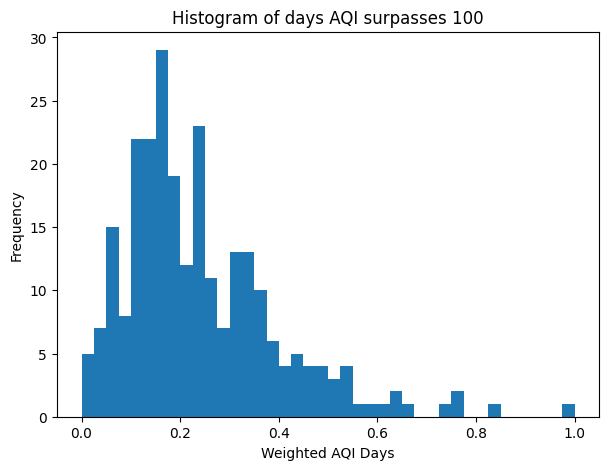

In [1698]:
df_air_by_county['Weighted AQI Days'] = (
        df_air_by_county['Weighted AQI Days'] - df_air_by_county['Weighted AQI Days'].min()
    ) / (df_air_by_county['Weighted AQI Days'].max() - df_air_by_county['Weighted AQI Days'].min())

# plot histogram of number of Weighted AQI Days
plt.figure(figsize=(7, 5))
plt.hist(df_air_by_county['Weighted AQI Days'], bins=40)
plt.xlabel('Weighted AQI Days')
plt.ylabel('Frequency')
plt.title('Histogram of days AQI surpasses 100')
plt.show()


257
0.1856705745266261
248


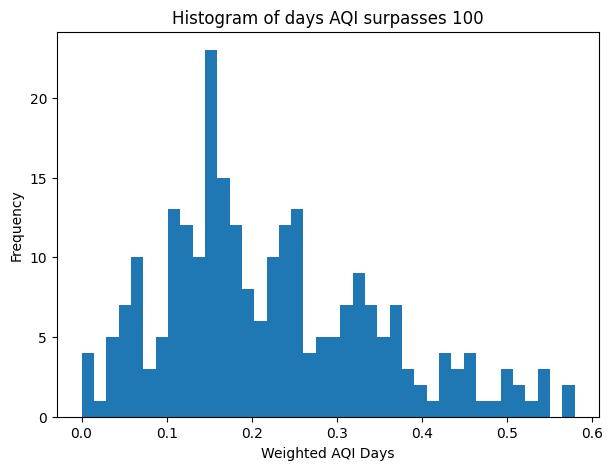

Rows removed: 9


In [1699]:
# Drop outliers based on IQR

Q1 = df_air_by_county['Weighted AQI Days'].quantile(0.25)
Q3 = df_air_by_county['Weighted AQI Days'].quantile(0.75)
iqr_value = Q3-Q1
lower_bound = Q1 - 1.5 * iqr_value
upper_bound = Q3 + 1.5 * iqr_value

print(len(df_air_by_county))

old = df_air_by_county
print(iqr_value)
df_air_by_county = df_air_by_county[
    (df_air_by_county['Weighted AQI Days'] >= lower_bound) &
    (df_air_by_county['Weighted AQI Days'] <= upper_bound)
]
print(len(df_air_by_county))

# replot 
plt.figure(figsize=(7, 5))
plt.hist(df_air_by_county['Weighted AQI Days'], bins=40)
plt.xlabel('Weighted AQI Days')
plt.ylabel('Frequency')
plt.title('Histogram of days AQI surpasses 100')
plt.show()

rows_removed = old.shape[0] - df_air_by_county.shape[0]
print(f"Rows removed: {rows_removed}") # Dropping 9 datapoints out of 257 = 3.5%


<Axes: xlabel='CountyName', ylabel='Weighted AQI Days'>

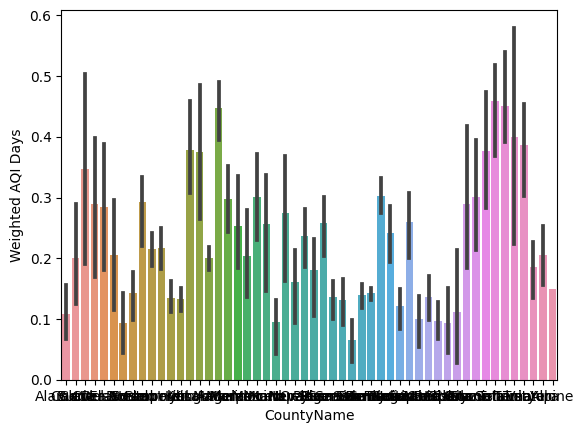

In [1700]:
# Bar plot of AQI by county
seaborn.barplot(data = df_air_by_county, x="CountyName", y="Weighted AQI Days")

## Merging

In [1701]:
df_hospital_pop_bycounty = df_hospital_pop_bycounty.rename(columns={"YEAR": "Year"})
# df_hospital_pop_bycounty.head(n=10)

In [1702]:
df_air_by_county["Year"] = df_air_by_county["Year"].astype("int64")
# df_air_by_county.head()

/var/folders/1d/gjghwm397n7cr3rpcndcs8rh0000gn/T/ipykernel_10933/1125998214.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_air_by_county["Year"] = df_air_by_county["Year"].astype("int64")


In [1703]:
# cleanup for merging

df_hospital_pop_bycounty.rename(columns={'YEAR': 'Year'}, inplace=True)
df_air_by_county['Year'] = df_air_by_county['Year'].astype('int64')


/var/folders/1d/gjghwm397n7cr3rpcndcs8rh0000gn/T/ipykernel_10933/96412565.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_air_by_county['Year'] = df_air_by_county['Year'].astype('int64')


In [1704]:
# merge AQI and hospital data
df_hospital_aqi = pd.merge(df_hospital_pop_bycounty[["CountyName", "Year", "VisitRate"]], df_air_by_county, on=["Year", "CountyName"], how='inner')
print(len(df_hospital_aqi))
df_hospital_aqi["Weighted AQI Days"] = df_hospital_aqi["Weighted AQI Days"].astype(float)
# df_hospital_aqi.head(n=50)

247


<Axes: xlabel='Weighted AQI Days', ylabel='VisitRate'>

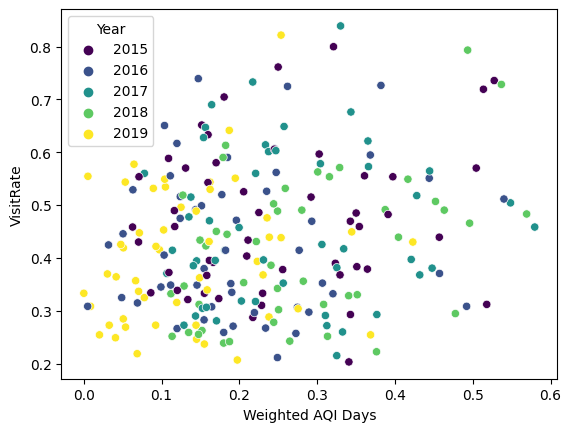

In [1705]:
seaborn.scatterplot(data=df_hospital_aqi, x='Weighted AQI Days', y='VisitRate', hue='Year', palette='viridis')

## Linear regression of visit rates vs weighted aqi days

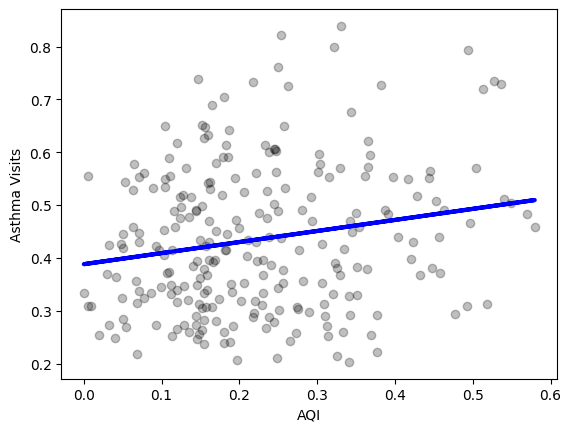

In [1706]:
import statsmodels.api as sm

df_hospital_aqi = df_hospital_aqi.dropna(subset=['VisitRate', 'Weighted AQI Days'])

x = df_hospital_aqi["Weighted AQI Days"]
y = df_hospital_aqi["VisitRate"]

# In order to have an intercept, we need to add a column of 1's to X
x2 = sm.add_constant(x)

# Fit the simple linear regression
sm_model = sm.OLS(y, x2)
results = sm_model.fit()

# Make predictions using the linear regression
y_pred = results.predict(x2)

# Plot 
plt.scatter(x, y,  color='black', alpha = 0.25)
plt.plot(x, y_pred, color='blue', linewidth=3)
plt.xlabel('AQI')
plt.ylabel('Asthma Visits')
plt.show()

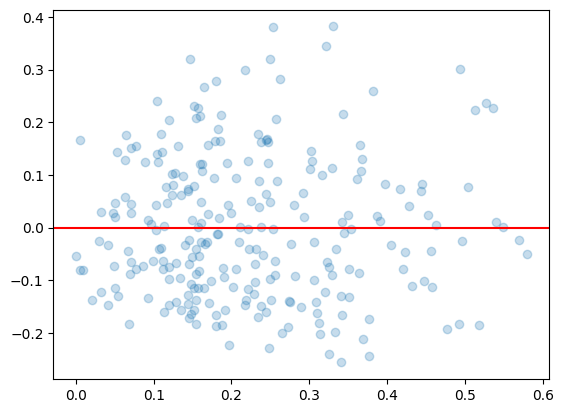

In [1707]:
# Enter code here to plot the residuals (Question 7a)
residuals = y - y_pred
plt.scatter(x, residuals, alpha = 0.25)
plt.axhline(y=0, color = 'red')
plt.show()

In [1708]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              VisitRate   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     9.528
Date:                Sat, 07 Dec 2024   Prob (F-statistic):            0.00226
Time:                        17:13:26   Log-Likelihood:                 143.92
No. Observations:                 247   AIC:                            -283.8
Df Residuals:                     245   BIC:                            -276.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.3881      0.01

## Get poverty, ethnicity data

In [1709]:
df_poverty = pd.read_csv('HDPulse_data_export.csv')
df_poverty = df_poverty[["County", "Value (Percent)"]]
df_poverty[">= 10%"] = df_poverty["Value (Percent)"] >= 10.0
df_poverty = df_poverty[~df_poverty["County"].isin(["United States", "California"])]
df_poverty.reset_index(drop=True, inplace=True)
df_poverty[">= 10%"] = df_poverty[">= 10%"].astype(int)
df_poverty = df_poverty.rename(columns={"County" : "CountyName"})
df_poverty["CountyName"] = df_poverty["CountyName"].str.replace(" County", "", regex=False)

In [1710]:
df_hospital_aqi_poverty = pd.merge(df_poverty[["CountyName", ">= 10%"]], df_hospital_aqi, on=["CountyName"])
print(len(df_hospital_aqi_poverty))
df_hospital_aqi_poverty.head()

247


,CountyName,>= 10%,Year,VisitRate,index,Weighted AQI Days
0,Imperial,1,2015,0.651418,0,0.151561
1,Imperial,1,2016,0.606587,0,0.245197
2,Imperial,1,2017,0.601098,0,0.237502
3,Imperial,1,2018,0.531565,0,0.258932
4,Imperial,1,2019,0.550778,0,0.194676


In [1711]:
# import cjest
df_cjest = pd.read_csv('1.0-communities.csv', low_memory=False)
df_cjest = df_cjest[df_cjest['State/Territory'] == 'California']
# Select only the desired columns
df_cjest = df_cjest[['Census tract 2010 ID', 
                     'County Name', 
                     'State/Territory', 
                     'Percent Black or African American alone', 
                     'Percent American Indian / Alaska Native', 
                     'Percent Asian', 
                     'Percent Native Hawaiian or Pacific', 
                     'Percent two or more races', 
                     'Percent White', 
                     'Percent Hispanic or Latino', 
                     'Percent other races', 
                     'Identified as disadvantaged', 
                     'Percentage of tract that is disadvantaged by area', 
                     'Total population', 
                     'Is low income?', 
                     'Adjusted percent of individuals below 200% Federal Poverty Line (percentile)', 
                     'Adjusted percent of individuals below 200% Federal Poverty Line']]

# Display the resulting dataframe
# df_cjest.head()

In [1713]:
# import pandas as pd
# import geopandas as gpd
# import matplotlib.pyplot as plt
# from mpl_toolkits.axes_grid1 import make_axes_locatable


# aqi_data = pd.read_csv('air_quality_2021.csv')

# CA_geo = gpd.read_file('tl_2019_06_cousub.shp')
# CA_geo.crs = "EPSG:4326"

# CA_geo = CA_geo.merge(aqi_data, left_on='COUNTY_NAME', right_on='County')

# fig, ax = plt.subplots(1, 1, figsize=(12, 10))
# divider = make_axes_locatable(ax)
# cax = divider.append_axes("right", size="5%", pad=0.1)


# CA_geo.plot(column='AQI', cmap='OrRd', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True, cax=cax)

# ax.set_title('California Air Quality Index (AQI) by County - 2021', fontdict={'fontsize': '15', 'fontweight' : '3'})
# ax.set_axis_off()

# plt.show()


## Get meteorology data

In [1714]:
file_path = 'data_meteorolgy.csv'  # File name provided
df = pd.read_csv(file_path)

# Convert the 'Date' column to datetime format if it's not already
df['Date'] = pd.to_datetime(df['Date'])

# Extract the year from the 'Date' column
df['Year'] = df['Date'].dt.year

# County and corresponding station map
county_station_map = {
    "Fresno": [2, 7, 39, 80, 105, 124, 205],
    "Kern": [5, 125, 146, 257],
    "Yolo": [6, 226],
    "Butte": [12, 244],
    "El Dorado": [13, 228],
    "Kings": [15],
    "Inyo": [35, 183],
    "Imperial": [41, 68, 87, 175, 181],
    "Shasta": [43, 224],
    "Riverside": [44, 62, 135, 136, 151, 179, 200, 208, 218, 237, 239, 240],
    "Contra Costa": [47, 170, 178, 213, 247],
    "San Luis Obispo": [52, 160, 163, 202, 265, 266],
    "Santa Barbara": [64, 88, 107, 165, 231, 232],
    "San Joaquin": [70, 242, 248, 249, 262],
    "Stanislaus": [71, 194, 206],
    "Orange": [75, 241, 245],
    "Napa": [77],
    "Los Angeles": [78, 99, 159, 174, 197, 204, 215, 216, 219, 220, 223],
    "Sonoma": [103, 144, 158, 83],
    "Yuba": [84],
    "Modoc": [90],
    "Siskiyou": [91, 225, 236, 260, 261],
    "Santa Cruz": [104, 209],
    "Mendocino": [106],
    "Monterey": [113, 114, 116, 129, 193, 210, 214, 229, 252],
    "San Bernardino": [117, 192, 199, 221, 233, 251],
    "San Benito": [126, 143],
    "Sacramento": [131, 140, 243],
    "San Diego": [147, 150, 153, 173, 184, 207],
    "Ventura": [152, 217],
    "Marin": [157, 187],
    "Tulare": [258, 182],
    "Alameda": [191, 254, 171],
    "Placer": [195],
    "Santa Clara": [211],
    "Tehama": [222],
    "Amador": [227],
    "Sutter": [235],
    "Alpine": [246],
    "Colusa": [250],
    "San Mateo": [253],
    "Humboldt": [259],
    "Del Norte": [263],
    "Plumas": [264],
    "Lassen": [267, 268],
    "San Francisco": [191, 178, 170, 47, 213, 247, 254],
    "Solano": [139, 212]
}

# Create a new DataFrame for county-level maximum averages
county_averages = []

# Iterate over each county and its corresponding stations
for county, stations in county_station_map.items():
    # Filter data for the specific stations
    county_data = df[df['Stn Id'].isin(stations)]
#     print(county_data)
    
    # Group the data by year and calculate the averages
    for date, group in county_data.groupby('Date'):
        avg_row = {
            "CountyName": county,
            "Date": date,
            "Avg Max Air Temp (F)": group["Max Air Temp (F)"].mean(),
            "Avg Max Rel Hum (%)": group["Max Rel Hum (%)"].mean()
        }
        county_averages.append(avg_row)

# Convert the list of averages to a DataFrame
county_df = pd.DataFrame(county_averages)

# county_df[county_df["CountyName"] == "Yolo"]

# # Save the county averages to a new CSV file
output_file = 'county_max_averages_daily.csv'
county_df.to_csv(output_file, index=False)



In [1715]:
county_df['CountyName'].unique()

array(['Fresno', 'Kern', 'Yolo', 'Butte', 'El Dorado', 'Kings', 'Inyo',
       'Imperial', 'Shasta', 'Riverside', 'Contra Costa',
       'San Luis Obispo', 'Santa Barbara', 'San Joaquin', 'Stanislaus',
       'Orange', 'Napa', 'Los Angeles', 'Sonoma', 'Yuba', 'Modoc',
       'Siskiyou', 'Santa Cruz', 'Mendocino', 'Monterey',
       'San Bernardino', 'San Benito', 'Sacramento', 'San Diego',
       'Ventura', 'Marin', 'Tulare', 'Alameda', 'Placer', 'Santa Clara',
       'Tehama', 'Amador', 'Sutter', 'Alpine', 'Colusa', 'San Mateo',
       'Humboldt', 'Del Norte', 'Plumas', 'San Francisco', 'Solano'],
      dtype=object)

In [1716]:
# Load the dataset
df_meteor = pd.read_csv('county_max_averages_daily.csv')

# Heat index calculation using the simplified formula
df_meteor['Heat Index'] = (0.5 * (
    df_meteor['Avg Max Air Temp (F)'] + 61 +
    ((df_meteor['Avg Max Air Temp (F)'] - 68) * 1.2) +
    (df_meteor['Avg Max Rel Hum (%)'] * 0.094)
) + df_meteor['Avg Max Air Temp (F)']) / 2

# Heat index calculation using the Rothfusz regression equation for HI > 80
df_meteor.loc[
    df_meteor['Heat Index'] > 80, 'Heat Index'
] = -42.379 + 2.04901523 * df_meteor['Avg Max Air Temp (F)'] + \
    10.14333127 * df_meteor['Avg Max Rel Hum (%)'] - \
    0.22475541 * df_meteor['Avg Max Air Temp (F)'] * df_meteor['Avg Max Rel Hum (%)'] - \
    0.00683783 * df_meteor['Avg Max Air Temp (F)']**2 - \
    0.05481717 * df_meteor['Avg Max Rel Hum (%)']**2 + \
    0.00122874 * df_meteor['Avg Max Rel Hum (%)'] * df_meteor['Avg Max Air Temp (F)']**2 + \
    0.00085282 * df_meteor['Avg Max Air Temp (F)'] * df_meteor['Avg Max Rel Hum (%)']**2 - \
    0.00000199 * (df_meteor['Avg Max Air Temp (F)']**2) * df_meteor['Avg Max Rel Hum (%)']**2

# Adjustment for RH < 13 and 80 < T < 112
df_meteor.loc[
    (df_meteor['Avg Max Rel Hum (%)'] < 13) &
    (df_meteor['Avg Max Air Temp (F)'] > 80) &
    (df_meteor['Avg Max Air Temp (F)'] < 112),
    'Heat Index'
] -= ((13 - df_meteor['Avg Max Rel Hum (%)']) / 4) * np.sqrt(
    (17 - np.abs(df_meteor['Avg Max Air Temp (F)'] - 95)) / 17
)

# Adjustment for RH > 85 and 80 < T < 87
df_meteor.loc[
    (df_meteor['Avg Max Rel Hum (%)'] > 85) &
    (df_meteor['Avg Max Air Temp (F)'] > 80) &
    (df_meteor['Avg Max Air Temp (F)'] < 87),
    'Heat Index'
] += ((df_meteor['Avg Max Rel Hum (%)'] - 85) / 10) * \
    ((87 - df_meteor['Avg Max Air Temp (F)']) / 5)

# Display the first few rows of the updated dataframe
df_meteor['Year'] = pd.to_datetime(df_meteor['Date']).dt.year
df_meteor.head(n=10)
print(df_meteor['CountyName'].unique())


['Fresno' 'Kern' 'Yolo' 'Butte' 'El Dorado' 'Kings' 'Inyo' 'Imperial'
 'Shasta' 'Riverside' 'Contra Costa' 'San Luis Obispo' 'Santa Barbara'
 'San Joaquin' 'Stanislaus' 'Orange' 'Napa' 'Los Angeles' 'Sonoma' 'Yuba'
 'Modoc' 'Siskiyou' 'Santa Cruz' 'Mendocino' 'Monterey' 'San Bernardino'
 'San Benito' 'Sacramento' 'San Diego' 'Ventura' 'Marin' 'Tulare'
 'Alameda' 'Placer' 'Santa Clara' 'Tehama' 'Amador' 'Sutter' 'Alpine'
 'Colusa' 'San Mateo' 'Humboldt' 'Del Norte' 'Plumas' 'San Francisco'
 'Solano']


/opt/homebrew/lib/python3.11/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [1717]:
# function to calculate weighted heat index days
# Class 1: 80-90, Class 2: 90-103, Class 3: 103-124, Class 4: >125
def make_weighted_hi_days_df(df):
        counts_df = pd.DataFrame(columns=['CountyName', 'Year', 'Weighted HI Days'])

        for year in df['Year'].unique():
                year_df = df[df['Year'] == year]
                for county in df['CountyName'].unique():
                        county_year_df = year_df[year_df['CountyName'] == county]
                        class_4 = (county_year_df['Heat Index'] > 125).sum()
                        class_3 = ((county_year_df['Heat Index'] > 103) & (county_year_df['Heat Index'] <= 125)).sum()
                        class_2 = ((county_year_df['Heat Index'] > 90) & (county_year_df['Heat Index'] <= 103)).sum()
                        class_1 = ((county_year_df['Heat Index'] > 80) & (county_year_df['Heat Index'] <= 90)).sum()

                        weighted_sum = 4 * class_4 + 3 * class_3 + 2 * class_2 + class_1

                        new_df_row = pd.DataFrame([[county, year, weighted_sum]], columns=['CountyName', 'Year', 'Weighted HI Days'])
                        counts_df = pd.concat([counts_df, new_df_row])

        return counts_df

In [1718]:
df_meteor = df_meteor[["CountyName", "Heat Index", "Year"]]
heat_index_df = make_weighted_hi_days_df(df_meteor)

# Scaling between 0 and 1
heat_index_df['Weighted HI Days'] = (
        heat_index_df['Weighted HI Days'] - heat_index_df['Weighted HI Days'].min()
    ) / (heat_index_df['Weighted HI Days'].max() - heat_index_df['Weighted HI Days'].min())


print(set(CA_counties) - set(heat_index_df['CountyName'].unique()))

{'Nevada', 'Mariposa', 'Mono', 'Calaveras', 'Merced', 'Madera', 'Lake', 'Trinity', 'Glenn'}


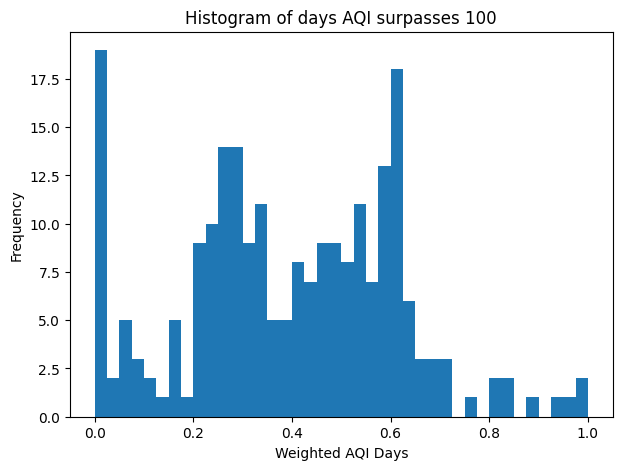

In [1719]:
# plot histogram of number of Weighted AQI Days
plt.figure(figsize=(7, 5))
plt.hist(heat_index_df['Weighted HI Days'], bins=40)
plt.xlabel('Weighted AQI Days')
plt.ylabel('Frequency')
plt.title('Histogram of days AQI surpasses 100')
plt.show()

In [1720]:
included_counties_df_hosp = df_hospital_aqi['CountyName'].unique()
print(len(included_counties_df_hosp))
included_counties_hi = heat_index_df['CountyName'].unique()
print(len(included_counties_hi))

df_hospital_aqi_heat = pd.merge(df_hospital_aqi[["CountyName", "Year", "VisitRate", "Weighted AQI Days"]], heat_index_df, on=["Year", "CountyName"], how='inner')
df_hospital_aqi_heat["Weighted HI Days"] = df_hospital_aqi_heat["Weighted HI Days"].astype(float)
df_hospital_aqi_heat_poverty = pd.merge(df_hospital_aqi_heat, df_hospital_aqi_poverty, on=["Year", "CountyName", "VisitRate", "Weighted AQI Days"], how='inner')
df_hospital_aqi_heat_poverty

51
46


,CountyName,Year,VisitRate,Weighted AQI Days,Weighted HI Days,>= 10%,index
0,Alameda,2015,0.588289,0.108904,0.291092,0,0
1,Alameda,2016,0.528820,0.063094,0.267252,0,0
2,Alameda,2017,0.515096,0.137614,0.452949,0,0
3,Alameda,2018,0.444648,0.184087,0.153074,0,0
4,Alameda,2019,0.419030,0.050837,0.219573,0,0
...,...,...,...,...,...,...,...
200,Yolo,2015,0.403477,0.209451,0.588457,0,0
201,Yolo,2016,0.351327,0.188953,0.535759,0,0
202,Yolo,2017,0.396157,0.230908,0.573400,0,0
203,Yolo,2018,0.355901,0.282086,0.588457,0,0


## Comparing included and excluded counties

In [1745]:
# Get CA counties we're using
used_county_list = df_hospital_aqi_heat['CountyName'].unique()
dropped_county_list = set(CA_counties) - set(used_county_list)
print("excluding: ", dropped_county_list)

excluding:  {'Nevada', 'Mariposa', 'Mono', 'Calaveras', 'Merced', 'Madera', 'Lake', 'Trinity', 'Glenn'}


In [1751]:
# t test for visit rate
#hypothesis testing for visit rate
from scipy.stats import ttest_ind

# Split the data into 'used' and 'dropped' counties
used_counties = df_hospital_bycounty[df_hospital_bycounty['CountyName'].isin(used_county_list)]
print(df_hospital_bycounty.columns)
dropped_counties = df_hospital_bycounty[df_hospital_bycounty['CountyName'].isin(dropped_county_list)] #TODO this info not included obvi so get from og sources
# print(dropped_counties)

# Perform the t-test for 'VisitRate'
used_visit_rate = df_hospital_aqi_heat['AGE-ADJUSTED ED VISIT RATE']
dropped_visit_rate = dropped_counties['AGE-ADJUSTED ED VISIT RATE']

# T-test
t_stat, p_value = ttest_ind(used_visit_rate, dropped_visit_rate, equal_var=False)  # Welch's t-test if unequal variances

print(f"T-statistic: {t_stat}, P-value: {p_value}")


Index(['CountyName', 'YEAR', 'AGE-ADJUSTED ED VISIT RATE'], dtype='object')


KeyError: 'AGE-ADJUSTED ED VISIT RATE'

In [1752]:
#check for normality
from scipy.stats import shapiro

stat_used, p_used = shapiro(used_visit_rate)
stat_dropped, p_dropped = shapiro(dropped_visit_rate)

print(f"Shapiro-Wilk Test for Used Counties: p-value = {p_used}")
print(f"Shapiro-Wilk Test for Dropped Counties: p-value = {p_dropped}")

# Not normal so T-statistic above invalid

Shapiro-Wilk Test for Used Counties: p-value = 8.876064384821802e-05
Shapiro-Wilk Test for Dropped Counties: p-value = 0.0241425558924675


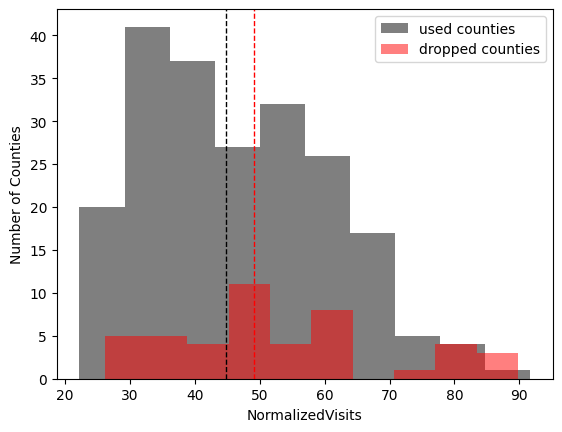

The p-value for the Moods Median test is  0.09458625486213693
The grand median (median for all both samples together) is  46.2
The contingency table is: 
 [[ 99  28]
 [111  17]]
There is NOT a statistically significant difference between the included and excluded counties


In [ ]:
# Moods median for ED visits
plt.hist(used_counties['AGE-ADJUSTED ED VISIT RATE'], 
         alpha=0.5, 
         color='black',
         label='used counties')
  
plt.hist(dropped_counties['AGE-ADJUSTED ED VISIT RATE'],
         alpha=0.5,
         color = 'red',
         label='dropped counties')

plt.axvline(used_counties['AGE-ADJUSTED ED VISIT RATE'].median(), color='black', linestyle='dashed', linewidth=1)
plt.axvline(dropped_counties['AGE-ADJUSTED ED VISIT RATE'].median(), color='red', linestyle='dashed', linewidth=1)

plt.legend(loc='upper right')
plt.xlabel('NormalizedVisits')
plt.ylabel('Number of Counties')
plt.show()


stat, p, med, tbl = median_test(used_counties['AGE-ADJUSTED ED VISIT RATE'], dropped_counties['AGE-ADJUSTED ED VISIT RATE'])
print('The p-value for the Moods Median test is ', p)
print('The grand median (median for all both samples together) is ', med)
print('The contingency table is: \n', tbl)
("For ED Visit Rate:")
if (p < 0.01):
        print("There IS a statistically significant difference between the included and excluded counties")
else: 
        print("There is NOT a statistically significant difference between the included and excluded counties")

In [ ]:
# split poverty by use
# Split percent hipanic by 'used' and 'dropped' counties
used_counties = df_hospital_bycounty[df_hospital_bycounty['CountyName'].isin(used_county_list)]
print(df_hospital_bycounty.columns)
dropped_counties = df_hospital_bycounty[df_hospital_bycounty['CountyName'].isin(dropped_county_list)] #TODO this info not included obvi so get from og sources

In [ ]:
df_poverty

# Split percent hipanic by 'used' and 'dropped' counties
used_counties = df_hospital_bycounty[df_hospital_bycounty['CountyName'].isin(used_county_list)]
print(df_hospital_bycounty.columns)
dropped_counties = df_hospital_bycounty[df_hospital_bycounty['CountyName'].isin(dropped_county_list)] #TODO this info not included obvi so get from og sources


In [ ]:
# Moods median for percent hispanic
plt.hist(used_counties['AGE-ADJUSTED ED VISIT RATE'], 
         alpha=0.5, 
         color='black',
         label='used counties')
  
plt.hist(dropped_counties['AGE-ADJUSTED ED VISIT RATE'],
         alpha=0.5,
         color = 'red',
         label='dropped counties')

plt.axvline(used_counties['AGE-ADJUSTED ED VISIT RATE'].median(), color='black', linestyle='dashed', linewidth=1)
plt.axvline(dropped_counties['AGE-ADJUSTED ED VISIT RATE'].median(), color='red', linestyle='dashed', linewidth=1)

plt.legend(loc='upper right')
plt.xlabel('NormalizedVisits')
plt.ylabel('Number of Counties')
plt.show()


stat, p, med, tbl = median_test(used_counties['AGE-ADJUSTED ED VISIT RATE'], dropped_counties['AGE-ADJUSTED ED VISIT RATE'])
print('The p-value for the Moods Median test is ', p)
print('The grand median (median for all both samples together) is ', med)
print('The contingency table is: \n', tbl)
("For ED Visit Rate:")
if (p < 0.01):
        print("There IS a statistically significant difference between the included and excluded counties")
else: 
        print("There is NOT a statistically significant difference between the included and excluded counties")

## Dividing along poverty lines

In [ ]:
poverty_county_data = df_hospital_aqi_heat_poverty[df_hospital_aqi_heat_poverty[">= 10%"] == True]
not_poverty_county_data = df_hospital_aqi_heat_poverty[df_hospital_aqi_heat_poverty[">= 10%"] == False]

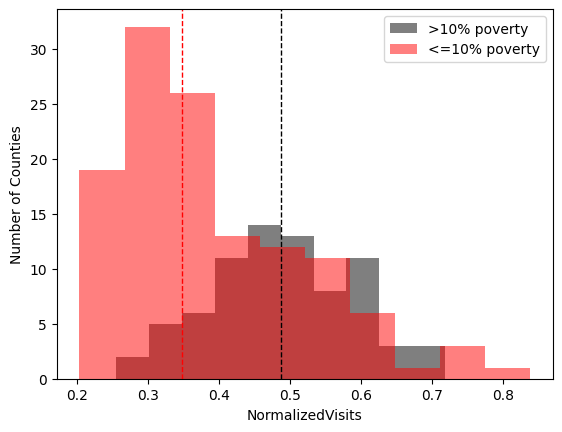

The p-value for the Moods Median test is  5.5433027331798344e-11
The grand median (median for all both samples together) is  0.4172003659652333
The contingency table is: 
 [[61 39]
 [15 85]]
There IS a statistically significant difference between the two poverty groups


In [ ]:
# CODE FOR TESTING FOR STATISTICALLY SIGNIFICANTLY DIFFERENT

plt.hist(poverty_county_data['VisitRate'], 
         alpha=0.5, # the transaparency parameter
         color='black',
         label='>10% poverty')
  
plt.hist(not_poverty_county_data['VisitRate'],
         alpha=0.5,
         color = 'red',
         label='<=10% poverty')

plt.axvline(poverty_county_data['VisitRate'].median(), color='black', linestyle='dashed', linewidth=1)
plt.axvline(not_poverty_county_data['VisitRate'].median(), color='red', linestyle='dashed', linewidth=1)

plt.legend(loc='upper right')
plt.xlabel('NormalizedVisits')
plt.ylabel('Number of Counties')
plt.show()


stat, p, med, tbl = median_test(poverty_county_data['VisitRate'], not_poverty_county_data['VisitRate'])
print('The p-value for the Moods Median test is ', p)
print('The grand median (median for all both samples together) is ', med)
print('The contingency table is: \n', tbl)
("For ED Visit Rate:")
if (p < 0.01):
        print("There IS a statistically significant difference between the two poverty groups")
else: 
        print("There is NOT a statistically significant difference between the two poverty groups")

/var/folders/1d/gjghwm397n7cr3rpcndcs8rh0000gn/T/ipykernel_10933/4130651876.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  not_poverty_county_data["VisitRate_Pred"] = y_pred_no_pov


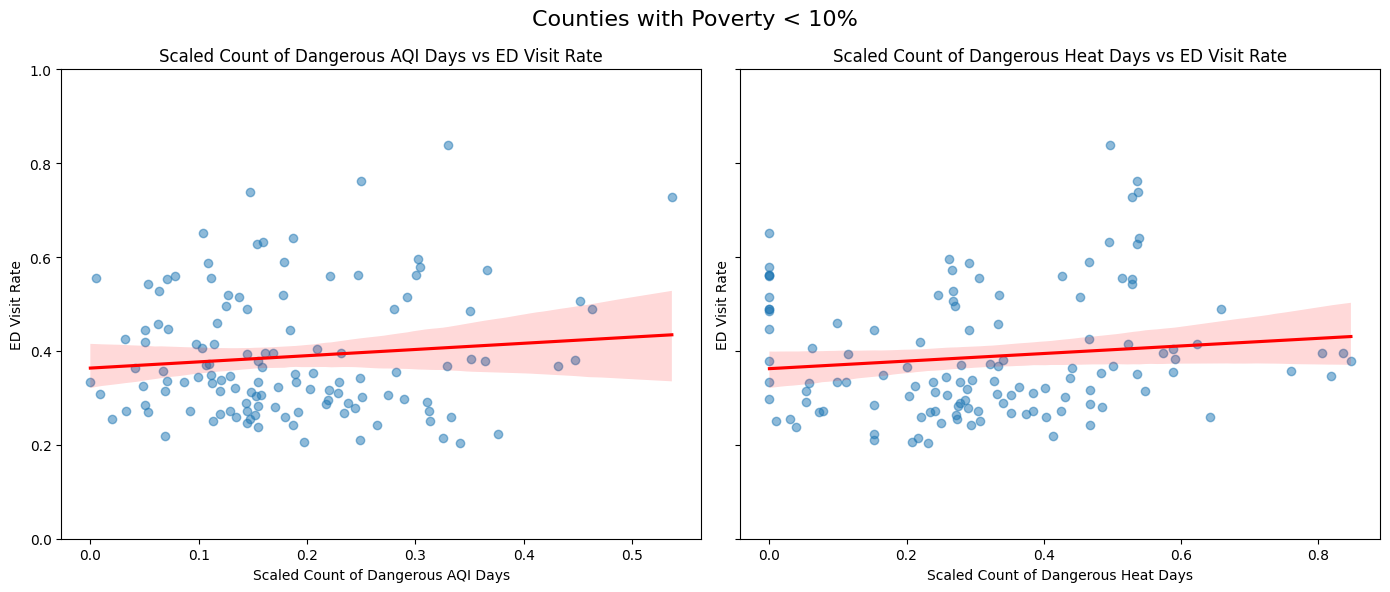

                            OLS Regression Results                            
Dep. Variable:              VisitRate   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     1.667
Date:                Sat, 07 Dec 2024   Prob (F-statistic):              0.193
Time:                        17:05:15   Log-Likelihood:                 76.243
No. Observations:                 124   AIC:                            -146.5
Df Residuals:                     121   BIC:                            -138.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.3382      0.03

In [ ]:
# linear regression on < 10% poverty 

x_no_pov = not_poverty_county_data[["Weighted AQI Days", "Weighted HI Days"]]
y_no_pov = not_poverty_county_data["VisitRate"]

# In order to have an intercept, we need to add a column of 1's to X
x2_no_pov = sm.add_constant(x_no_pov)

# Fit the simple linear regression
sm_model_no_pov = sm.OLS(y_no_pov, x2_no_pov)
results_no_pov= sm_model_no_pov.fit()

# Make predictions using the linear regression
y_pred_no_pov = results_no_pov.predict(x2_no_pov)

import seaborn as sns
import matplotlib.pyplot as plt

# Add predicted VisitRate to the DataFrame
not_poverty_county_data["VisitRate_Pred"] = y_pred_no_pov

# Plotting the relationship between each predictor and VisitRate
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Plot 1: Weighted AQI Days vs VisitRate
sns.regplot(
    ax=axes[0],
    x="Weighted AQI Days",
    y="VisitRate",
    data=not_poverty_county_data,
    scatter_kws={"alpha": 0.5},
    line_kws={"color": "red"}
)
axes[0].set_ylim(0, 1)
axes[0].set_title("Scaled Count of Dangerous AQI Days vs ED Visit Rate")
axes[0].set_xlabel("Scaled Count of Dangerous AQI Days")
axes[0].set_ylabel("ED Visit Rate")

# Plot 2: Weighted HI Days vs VisitRate
sns.regplot(
    ax=axes[1],
    x="Weighted HI Days",
    y="VisitRate",
    data=not_poverty_county_data,
    scatter_kws={"alpha": 0.5},
    line_kws={"color": "red"}
)
axes[1].set_ylim(0, 1)
axes[1].set_title("Scaled Count of Dangerous Heat Days vs ED Visit Rate")
axes[1].set_xlabel("Scaled Count of Dangerous Heat Days")
axes[1].set_ylabel("ED Visit Rate")

fig.suptitle("Counties with Poverty < 10%", fontsize=16)

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

print(results_no_pov.summary())

/var/folders/1d/gjghwm397n7cr3rpcndcs8rh0000gn/T/ipykernel_10933/1520898941.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  poverty_county_data["VisitRate_Pred"] = y_pred_pov


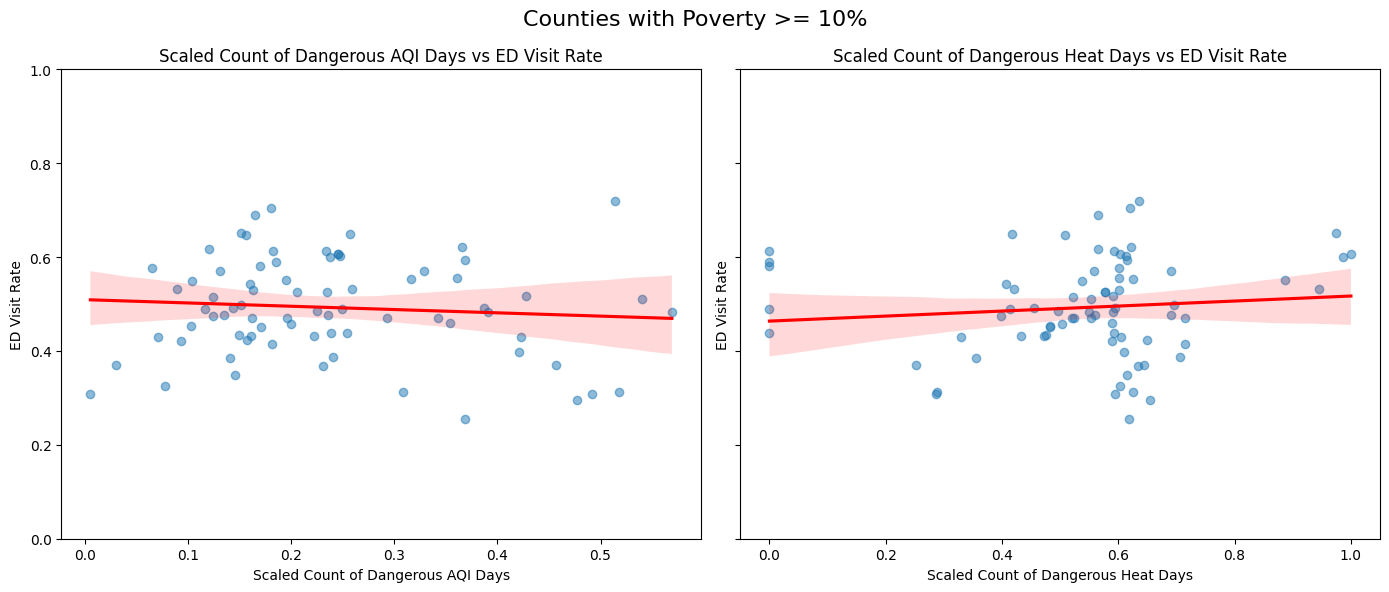

                            OLS Regression Results                            
Dep. Variable:              VisitRate   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.8777
Date:                Sat, 07 Dec 2024   Prob (F-statistic):              0.420
Time:                        17:05:15   Log-Likelihood:                 66.285
No. Observations:                  76   AIC:                            -126.6
Df Residuals:                      73   BIC:                            -119.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.4789      0.03

In [ ]:
x_pov = poverty_county_data[["Weighted AQI Days", "Weighted HI Days"]]
y_pov = poverty_county_data["VisitRate"]

# In order to have an intercept, we need to add a column of 1's to X
x2_pov = sm.add_constant(x_pov)

# Fit the simple linear regression
sm_model_pov = sm.OLS(y_pov, x2_pov)
results_pov= sm_model_pov.fit()

# Make predictions using the linear regression
y_pred_pov = results_pov.predict(x2_pov)

# Add predicted VisitRate to the DataFrame
poverty_county_data["VisitRate_Pred"] = y_pred_pov

# Plotting the relationship between each predictor and VisitRate
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Plot 1: Weighted AQI Days vs VisitRate
sns.regplot(
    ax=axes[0],
    x="Weighted AQI Days",
    y="VisitRate",
    data=poverty_county_data,
    scatter_kws={"alpha": 0.5},
    line_kws={"color": "red"}
)
axes[0].set_ylim(0, 1)
axes[0].set_title("Scaled Count of Dangerous AQI Days vs ED Visit Rate")
axes[0].set_xlabel("Scaled Count of Dangerous AQI Days")
axes[0].set_ylabel("ED Visit Rate")

# Plot 2: Weighted HI Days vs VisitRate
sns.regplot(
    ax=axes[1],
    x="Weighted HI Days",
    y="VisitRate",
    data=poverty_county_data,
    scatter_kws={"alpha": 0.5},
    line_kws={"color": "red"}
)
axes[1].set_ylim(0, 1)
axes[1].set_title("Scaled Count of Dangerous Heat Days vs ED Visit Rate")
axes[1].set_xlabel("Scaled Count of Dangerous Heat Days")
axes[1].set_ylabel("ED Visit Rate")

fig.suptitle("Counties with Poverty >= 10%", fontsize=16)

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

print(results_pov.summary())

In [ ]:
df_ethnicity = pd.read_csv('ethnicity.csv', encoding = "ISO-8859-1")
df_ethnicity = df_ethnicity[["Geography", "Total Population - Estimate", "Hispanic or Latino - Estimate"]]
df_ethnicity['Total Population - Estimate'] = df_ethnicity['Total Population - Estimate'].str.replace(',', '', regex=False).astype(float)
df_ethnicity['Hispanic or Latino - Estimate'] = df_ethnicity['Hispanic or Latino - Estimate'].str.replace(',', '', regex=False).astype(float)
df_ethnicity = df_ethnicity[df_ethnicity['Geography'].str.contains('County', case=False, na=False)]
df_ethnicity = df_ethnicity[~df_ethnicity['Geography'].str.contains('County\\)', case=False, na=False)]
df_ethnicity['Geography'] = df_ethnicity['Geography'].str.replace(' County', '', regex=False)
df_ethnicity["Total Population - Estimate"] = pd.to_numeric(df_ethnicity["Total Population - Estimate"], errors='coerce')
df_ethnicity['Hispanic or Latino - Estimate'] = pd.to_numeric(df_ethnicity['Hispanic or Latino - Estimate'], errors='coerce')
df_ethnicity["% Hispanic/Latino"] = df_ethnicity["Hispanic or Latino - Estimate"] / df_ethnicity["Total Population - Estimate"]

df_ethnicity = df_ethnicity[["Geography", "% Hispanic/Latino"]]
df_ethnicity["Majority Hisp"] = df_ethnicity["% Hispanic/Latino"] >= 0.25 # todo this could be changed, set it here to get about half and half 
print(df_ethnicity["Majority Hisp"].sum())
df_ethnicity = df_ethnicity.rename(columns={"Geography" : "CountyName"})
df_ethnicity["Majority Hisp"] = df_ethnicity["Majority Hisp"].astype(int)
df_ethnicity.head()

31


,CountyName,% Hispanic/Latino,Majority Hisp
1,Alameda,0.223943,0
22,Alpine,0.125120,0
28,Amador,0.138958,0
47,Butte,0.163478,0
78,Calaveras,0.120600,0


In [ ]:
df_hospital_aqi_heat_poverty_ethn = pd.merge(df_hospital_aqi_heat_poverty, df_ethnicity, on=["CountyName"], how='inner')
df_hospital_aqi_heat_poverty_hisp = df_hospital_aqi_heat_poverty_ethn[df_hospital_aqi_heat_poverty_ethn["Majority Hisp"] == 1]
df_hospital_aqi_heat_poverty_not_hisp = df_hospital_aqi_heat_poverty_ethn[df_hospital_aqi_heat_poverty_ethn["Majority Hisp"] == 0]

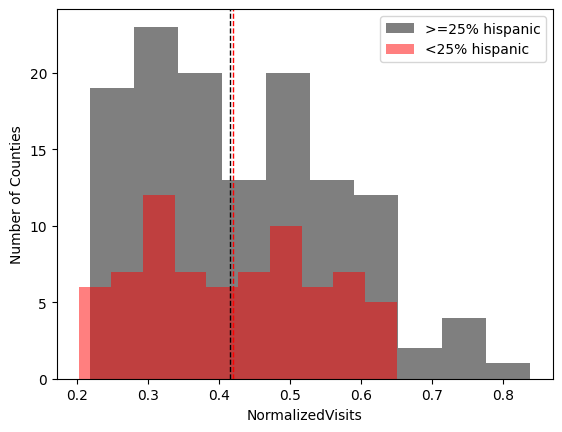

The p-value for the Moods Median test is  1.0
The grand median (median for all both samples together) is  0.4172003659652333
The contingency table is: 
 [[63 37]
 [64 36]]
There is NOT a statistically significant difference between the two hispanic groups


In [ ]:
# CODE FOR TESTING FOR STATISTICALLY SIGNIFICANTLY DIFFERENT

plt.hist(df_hospital_aqi_heat_poverty_hisp['VisitRate'], 
         alpha=0.5, 
         color='black',
         label='>=25% hispanic')
  
plt.hist(df_hospital_aqi_heat_poverty_not_hisp['VisitRate'],
         alpha=0.5,
         color = 'red',
         label='<25% hispanic')

plt.axvline(df_hospital_aqi_heat_poverty_hisp['VisitRate'].median(), color='black', linestyle='dashed', linewidth=1)
plt.axvline(df_hospital_aqi_heat_poverty_not_hisp['VisitRate'].median(), color='red', linestyle='dashed', linewidth=1)

plt.legend(loc='upper right')
plt.xlabel('NormalizedVisits')
plt.ylabel('Number of Counties')
plt.show()


stat, p, med, tbl = median_test(df_hospital_aqi_heat_poverty_hisp['VisitRate'], df_hospital_aqi_heat_poverty_not_hisp['VisitRate'])
print('The p-value for the Moods Median test is ', p)
print('The grand median (median for all both samples together) is ', med)
print('The contingency table is: \n', tbl)
("For ED Visit Rate:")
if (p < 0.01):
        print("There IS a statistically significant difference between the two hispanic groups")
else: 
        print("There is NOT a statistically significant difference between the two hispanic groups")

HISPANIC MAJORITY COUNTIES


/var/folders/1d/gjghwm397n7cr3rpcndcs8rh0000gn/T/ipykernel_10933/3782127667.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hospital_aqi_heat_poverty_hisp["VisitRate_Pred"] = y_pred_hisp


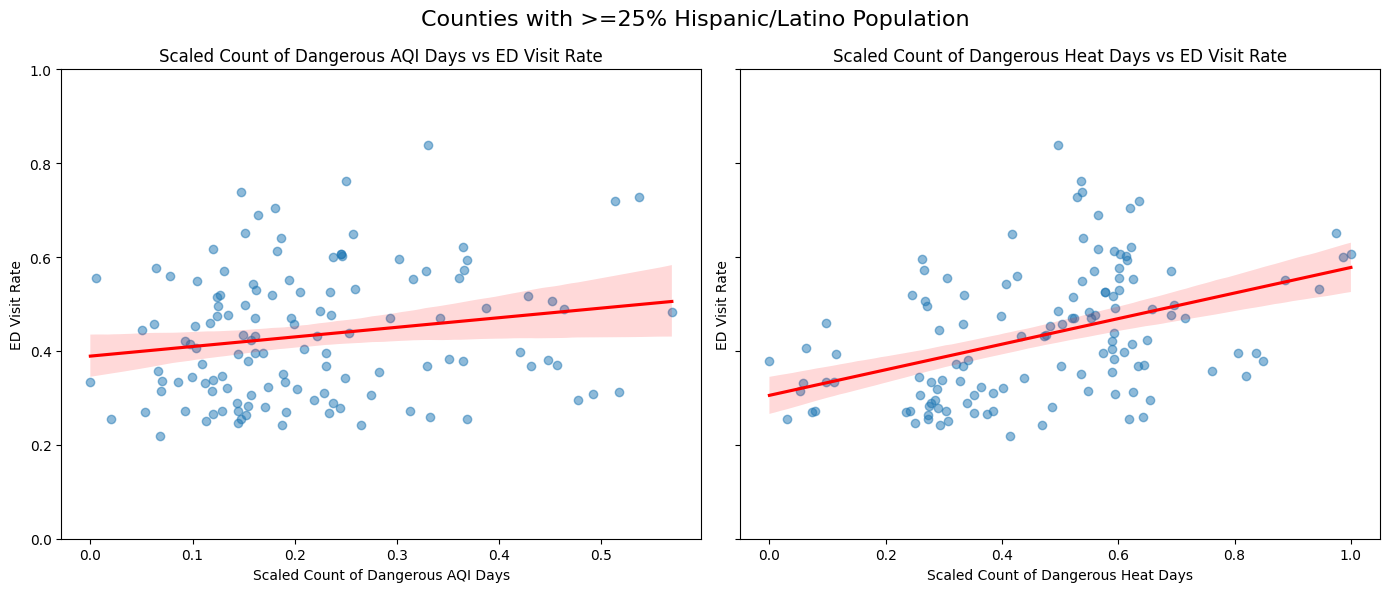

                            OLS Regression Results                            
Dep. Variable:              VisitRate   R-squared:                       0.183
Model:                            OLS   Adj. R-squared:                  0.170
Method:                 Least Squares   F-statistic:                     13.89
Date:                Sat, 07 Dec 2024   Prob (F-statistic):           3.61e-06
Time:                        17:05:16   Log-Likelihood:                 85.948
No. Observations:                 127   AIC:                            -165.9
Df Residuals:                     124   BIC:                            -157.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.2950      0.03

In [ ]:
# linear regression > 25% hispanic

x_hisp = df_hospital_aqi_heat_poverty_hisp[["Weighted AQI Days", "Weighted HI Days"]]
y_hisp = df_hospital_aqi_heat_poverty_hisp["VisitRate"]

# In order to have an intercept, we need to add a column of 1's to X
x2_hisp = sm.add_constant(x_hisp)

# Fit the simple linear regression
sm_model_hisp = sm.OLS(y_hisp, x2_hisp)
results_hisp= sm_model_hisp.fit()

# Make predictions using the linear regression
y_pred_hisp = results_hisp.predict(x2_hisp)

import seaborn as sns
import matplotlib.pyplot as plt

# Add predicted VisitRate to the DataFrame
df_hospital_aqi_heat_poverty_hisp["VisitRate_Pred"] = y_pred_hisp

# Plotting the relationship between each predictor and VisitRate
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Plot 1: Weighted AQI Days vs VisitRate
sns.regplot(
    ax=axes[0],
    x="Weighted AQI Days",
    y="VisitRate",
    data=df_hospital_aqi_heat_poverty_hisp,
    scatter_kws={"alpha": 0.5},
    line_kws={"color": "red"}
)
axes[0].set_ylim(0, 1)
axes[0].set_title("Scaled Count of Dangerous AQI Days vs ED Visit Rate")
axes[0].set_xlabel("Scaled Count of Dangerous AQI Days")
axes[0].set_ylabel("ED Visit Rate")

# Plot 2: Weighted HI Days vs VisitRate
sns.regplot(
    ax=axes[1],
    x="Weighted HI Days",
    y="VisitRate",
    data=df_hospital_aqi_heat_poverty_hisp,
    scatter_kws={"alpha": 0.5},
    line_kws={"color": "red"}
)
axes[1].set_ylim(0, 1)
axes[1].set_title("Scaled Count of Dangerous Heat Days vs ED Visit Rate")
axes[1].set_xlabel("Scaled Count of Dangerous Heat Days")
axes[1].set_ylabel("ED Visit Rate")

fig.suptitle("Counties with >=25% Hispanic/Latino Population", fontsize=16)

# Adjust layout and display the plots
print("HISPANIC MAJORITY COUNTIES")
plt.tight_layout()
plt.show()

print(results_hisp.summary())

/var/folders/1d/gjghwm397n7cr3rpcndcs8rh0000gn/T/ipykernel_10933/3076242487.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hospital_aqi_heat_poverty_not_hisp["VisitRate_Pred"] = y_pred_not_hisp


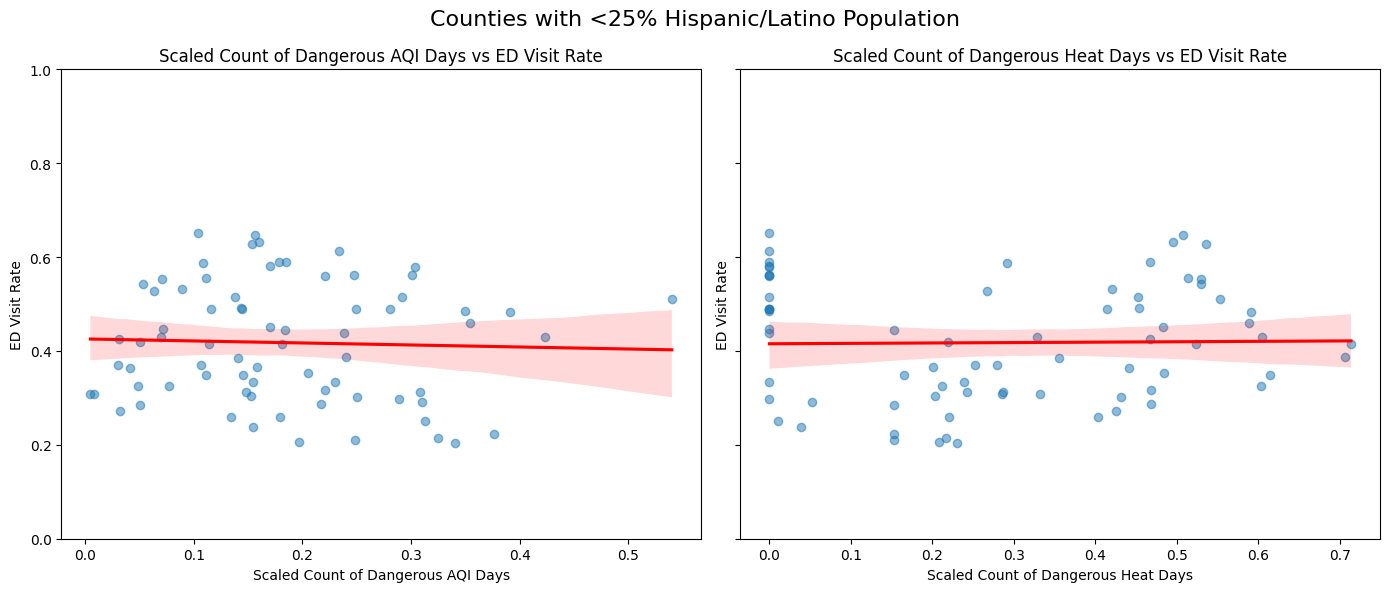

                            OLS Regression Results                            
Dep. Variable:              VisitRate   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.027
Method:                 Least Squares   F-statistic:                   0.05256
Date:                Sat, 07 Dec 2024   Prob (F-statistic):              0.949
Time:                        17:05:16   Log-Likelihood:                 48.494
No. Observations:                  73   AIC:                            -90.99
Df Residuals:                      70   BIC:                            -84.12
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.4237      0.03

In [ ]:
# linear regression < 25% hispanic

x_not_hisp = df_hospital_aqi_heat_poverty_not_hisp[["Weighted AQI Days", "Weighted HI Days"]]
y_not_hisp = df_hospital_aqi_heat_poverty_not_hisp["VisitRate"]

# In order to have an intercept, we need to add a column of 1's to X
x2_not_hisp = sm.add_constant(x_not_hisp)

# Fit the simple linear regression
sm_model_not_hisp = sm.OLS(y_not_hisp, x2_not_hisp)
results_not_hisp= sm_model_not_hisp.fit()

# Make predictions using the linear regression
y_pred_not_hisp = results_not_hisp.predict(x2_not_hisp)

# Add predicted VisitRate to the DataFrame
df_hospital_aqi_heat_poverty_not_hisp["VisitRate_Pred"] = y_pred_not_hisp

# Plotting the relationship between each predictor and VisitRate
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Plot 1: Weighted AQI Days vs VisitRate
sns.regplot(
    ax=axes[0],
    x="Weighted AQI Days",
    y="VisitRate",
    data=df_hospital_aqi_heat_poverty_not_hisp,
    scatter_kws={"alpha": 0.5},
    line_kws={"color": "red"}
)
axes[0].set_ylim(0, 1)
axes[0].set_title("Scaled Count of Dangerous AQI Days vs ED Visit Rate")
axes[0].set_xlabel("Scaled Count of Dangerous AQI Days")
axes[0].set_ylabel("ED Visit Rate")

# Plot 2: WarningHeatDays vs VisitRate
sns.regplot(
    ax=axes[1],
    x="Weighted HI Days",
    y="VisitRate",
    data=df_hospital_aqi_heat_poverty_not_hisp,
    scatter_kws={"alpha": 0.5},
    line_kws={"color": "red"}
)
axes[1].set_ylim(0, 1)
axes[1].set_title("Scaled Count of Dangerous Heat Days vs ED Visit Rate")
axes[1].set_xlabel("Scaled Count of Dangerous Heat Days")
axes[1].set_ylabel("ED Visit Rate")

fig.suptitle("Counties with <25% Hispanic/Latino Population", fontsize=16)

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

print(results_not_hisp.summary())

In [ ]:
df_insurance = pd.read_csv('Health_Insurance_Coverage_-_by_County.csv', encoding = "ISO-8859-1")
df_insurance = df_insurance[["GEO_NAME", "Percent of Population with No Health Insurance Coverage"]]
df_insurance = df_insurance.rename(columns={"GEO_NAME" : "CountyName"})
df_insurance["CountyName"] = df_insurance["CountyName"].str.replace(" County", "", regex=False)
df_insurance["Lacking Insurance"] = df_insurance["Percent of Population with No Health Insurance Coverage"] > 7.5
df_insurance["Lacking Insurance"] = df_insurance["Lacking Insurance"].astype(int)

df_hospital_aqi_heat_poverty_ethn_insurance = pd.merge(df_hospital_aqi_heat_poverty_ethn, df_insurance[["CountyName", "Lacking Insurance"]], on=["CountyName"], how='inner')
# df_hospital_aqi_heat_poverty_ethn_insurance
df_less_insurance = df_hospital_aqi_heat_poverty_ethn_insurance[df_hospital_aqi_heat_poverty_ethn_insurance["Lacking Insurance"] == 1]
df_more_insurance = df_hospital_aqi_heat_poverty_ethn_insurance[df_hospital_aqi_heat_poverty_ethn_insurance["Lacking Insurance"] == 0]


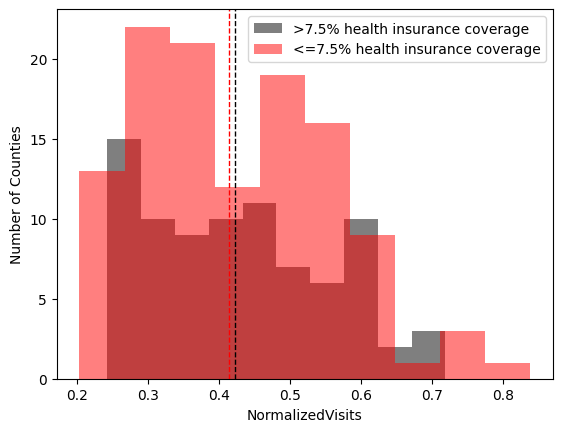

The p-value for the Moods Median test is  0.7740965731139413
The grand median (median for all both samples together) is  0.4172003659652333
The contingency table is: 
 [[43 57]
 [40 60]]
There is NOT a statistically significant difference between the two insurance groups


In [1750]:
# CODE FOR TESTING FOR STATISTICALLY SIGNIFICANTLY DIFFERENT

plt.hist(df_less_insurance['VisitRate'], 
         alpha=0.5, 
         color='black',
         label='>7.5% health insurance coverage')
  
plt.hist(df_more_insurance['VisitRate'],
         alpha=0.5,
         color = 'red',
         label='<=7.5% health insurance coverage')

plt.axvline(df_less_insurance['VisitRate'].median(), color='black', linestyle='dashed', linewidth=1)
plt.axvline(df_more_insurance['VisitRate'].median(), color='red', linestyle='dashed', linewidth=1)

plt.legend(loc='upper right')
plt.xlabel('NormalizedVisits')
plt.ylabel('Number of Counties')
plt.show()


stat, p, med, tbl = median_test(df_less_insurance['VisitRate'], df_more_insurance['VisitRate'])
print('The p-value for the Moods Median test is ', p)
print('The grand median (median for all both samples together) is ', med)
print('The contingency table is: \n', tbl)
("For ED Visit Rate:")
if (p < 0.01):
        print("There IS a statistically significant difference between the two insurance groups")
else: 
        print("There is NOT a statistically significant difference between the two insurance groups")

>7.5% LACKING INSURANCE


/var/folders/1d/gjghwm397n7cr3rpcndcs8rh0000gn/T/ipykernel_10933/2672680607.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_less_insurance["VisitRate_Pred"] = y_pred_less_insurance


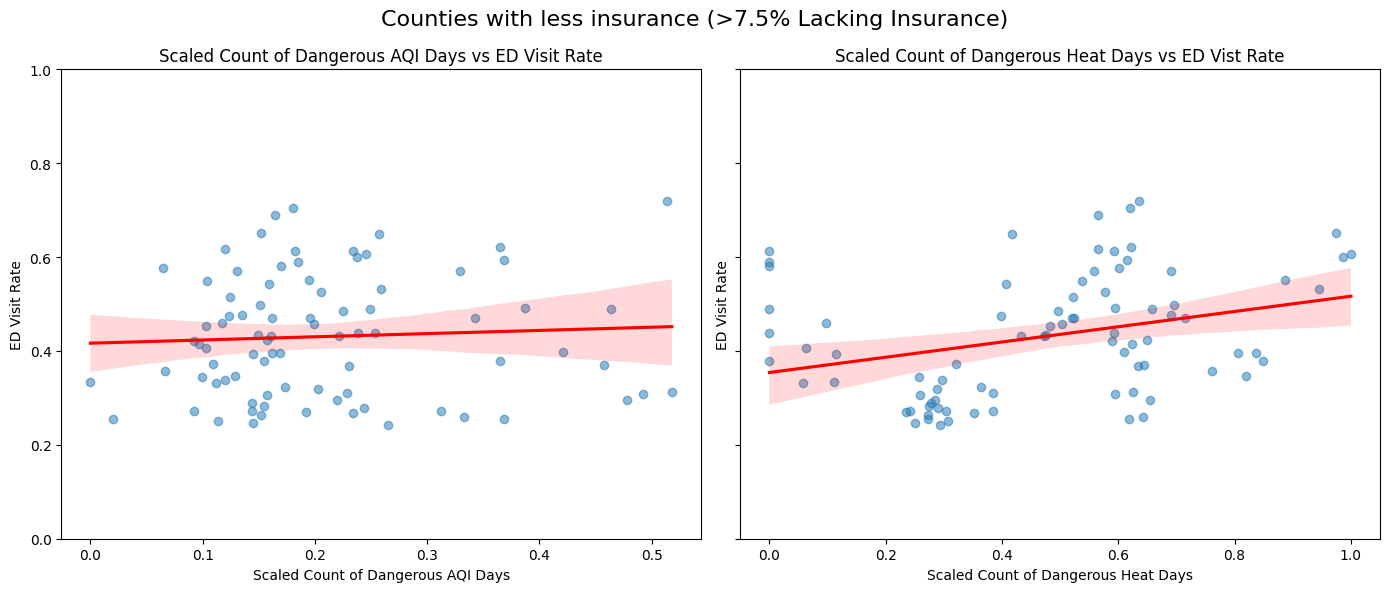

                            OLS Regression Results                            
Dep. Variable:              VisitRate   R-squared:                       0.103
Model:                            OLS   Adj. R-squared:                  0.080
Method:                 Least Squares   F-statistic:                     4.582
Date:                Sat, 07 Dec 2024   Prob (F-statistic):             0.0131
Time:                        17:05:16   Log-Likelihood:                 57.524
No. Observations:                  83   AIC:                            -109.0
Df Residuals:                      80   BIC:                            -101.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.3567      0.03

In [ ]:
# linear regression > 7.5% lacking insurance

x_less_insurance = df_less_insurance[["Weighted AQI Days", "Weighted HI Days"]]
y_less_insurance = df_less_insurance["VisitRate"]

# In order to have an intercept, we need to add a column of 1's to X
x2_less_insurance = sm.add_constant(x_less_insurance)

# Fit the simple linear regression
sm_model_less_insurance = sm.OLS(y_less_insurance, x2_less_insurance)
results_less_insurance = sm_model_less_insurance.fit()

# Make predictions using the linear regression
y_pred_less_insurance = results_less_insurance.predict(x2_less_insurance)

# Add predicted VisitRate to the DataFrame
df_less_insurance["VisitRate_Pred"] = y_pred_less_insurance

# Plotting the relationship between each predictor and VisitRate
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Plot 1: Weighted AQI Days vs VisitRate
sns.regplot(
    ax=axes[0],
    x="Weighted AQI Days",
    y="VisitRate",
    data=df_less_insurance,
    scatter_kws={"alpha": 0.5},
    line_kws={"color": "red"}
)
axes[0].set_ylim(0, 1)
axes[0].set_title("Scaled Count of Dangerous AQI Days vs ED Visit Rate")
axes[0].set_xlabel("Scaled Count of Dangerous AQI Days")
axes[0].set_ylabel("ED Visit Rate")

# Plot 2: WarningHeatDays vs VisitRate
sns.regplot(
    ax=axes[1],
    x="Weighted HI Days",
    y="VisitRate",
    data=df_less_insurance,
    scatter_kws={"alpha": 0.5},
    line_kws={"color": "red"}
)
axes[1].set_ylim(0, 1)
axes[1].set_title("Scaled Count of Dangerous Heat Days vs ED Vist Rate")
axes[1].set_xlabel("Scaled Count of Dangerous Heat Days")
axes[1].set_ylabel("ED Visit Rate")

fig.suptitle("Counties with less insurance (>7.5% Lacking Insurance)", fontsize=16)

# Adjust layout and display the plots
print(">7.5% LACKING INSURANCE")
plt.tight_layout()
plt.show()

print(results_less_insurance.summary())

/var/folders/1d/gjghwm397n7cr3rpcndcs8rh0000gn/T/ipykernel_10933/3575674364.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_more_insurance["VisitRate_Pred"] = y_pred_more_insurance


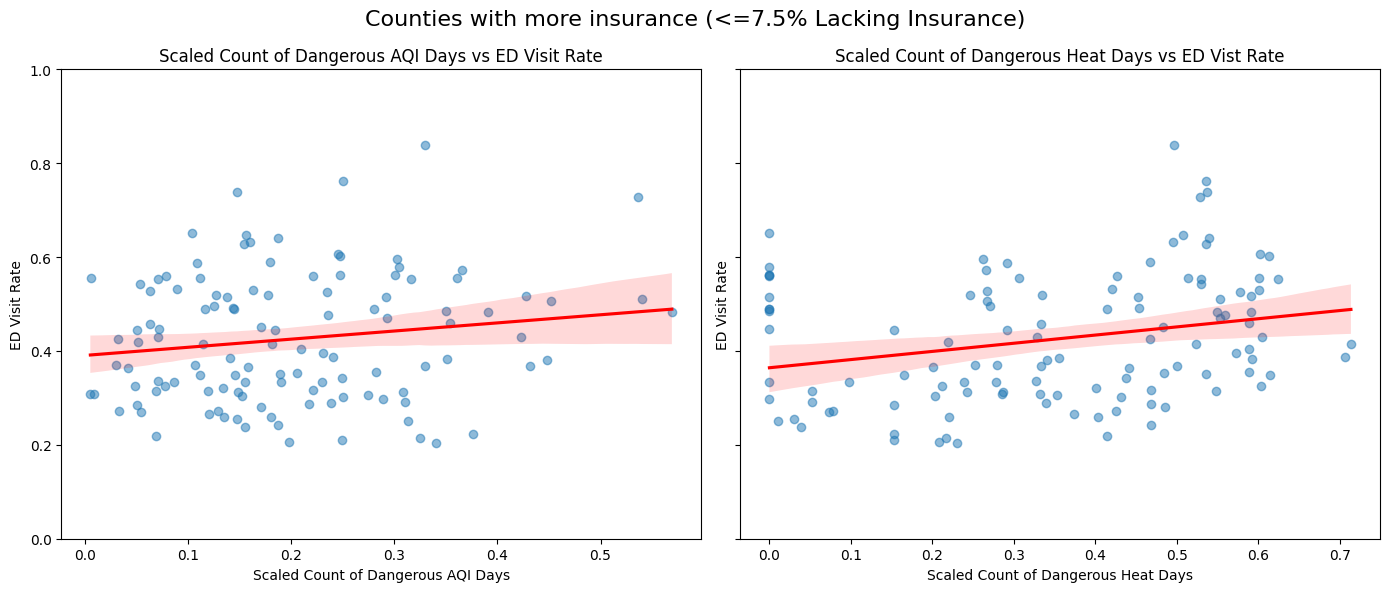

                            OLS Regression Results                            
Dep. Variable:              VisitRate   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                  0.065
Method:                 Least Squares   F-statistic:                     5.027
Date:                Sat, 07 Dec 2024   Prob (F-statistic):            0.00809
Time:                        17:05:16   Log-Likelihood:                 73.008
No. Observations:                 117   AIC:                            -140.0
Df Residuals:                     114   BIC:                            -131.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.3411      0.03

In [ ]:
# linear regression < 7.5% lacking insurance

x_more_insurance = df_more_insurance[["Weighted AQI Days", "Weighted HI Days"]]
y_more_insurance = df_more_insurance["VisitRate"]

# In order to have an intercept, we need to add a column of 1's to X
x2_more_insurance = sm.add_constant(x_more_insurance)

# Fit the simple linear regression
sm_model_more_insurance = sm.OLS(y_more_insurance, x2_more_insurance)
results_more_insurance = sm_model_more_insurance.fit()

# Make predictions using the linear regression
y_pred_more_insurance = results_more_insurance.predict(x2_more_insurance)

# Add predicted VisitRate to the DataFrame
df_more_insurance["VisitRate_Pred"] = y_pred_more_insurance

# Plotting the relationship between each predictor and VisitRate
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Plot 1: Weighted AQI Days vs VisitRate
sns.regplot(
    ax=axes[0],
    x="Weighted AQI Days",
    y="VisitRate",
    data=df_more_insurance,
    scatter_kws={"alpha": 0.5},
    line_kws={"color": "red"}
)
axes[0].set_ylim(0, 1)
axes[0].set_title("Scaled Count of Dangerous AQI Days vs ED Visit Rate")
axes[0].set_xlabel("Scaled Count of Dangerous AQI Days")
axes[0].set_ylabel("ED Visit Rate")

# Plot 2: WarningHeatDays vs VisitRate
sns.regplot(
    ax=axes[1],
    x="Weighted HI Days",
    y="VisitRate",
    data=df_more_insurance,
    scatter_kws={"alpha": 0.5},
    line_kws={"color": "red"}
)
axes[1].set_ylim(0, 1)
axes[1].set_title("Scaled Count of Dangerous Heat Days vs ED Vist Rate")
axes[1].set_xlabel("Scaled Count of Dangerous Heat Days")
axes[1].set_ylabel("ED Visit Rate")

fig.suptitle("Counties with more insurance (<=7.5% Lacking Insurance)", fontsize=16)


# Adjust layout and display the plots
plt.tight_layout()
plt.show()

print(results_more_insurance.summary())

In [ ]:
#Shapiro Wilks Test

residuals = y - y_pred

# Perform the Shapiro-Wilk test on residuals
from scipy.stats import shapiro
stat, p_value = shapiro(residuals)

# Print the results
print("Shapiro-Wilk Test Statistic:", stat)
print("p-value:", p_value)

# Interpret the results
if p_value > 0.05:
    print("Residuals appear to be normally distributed (fail to reject H0).")
else:
    print("Residuals do not appear to be normally distributed (reject H0).")

Shapiro-Wilk Test Statistic: 0.9732674956321716
p-value: 0.0001331914827460423
Residuals do not appear to be normally distributed (reject H0).


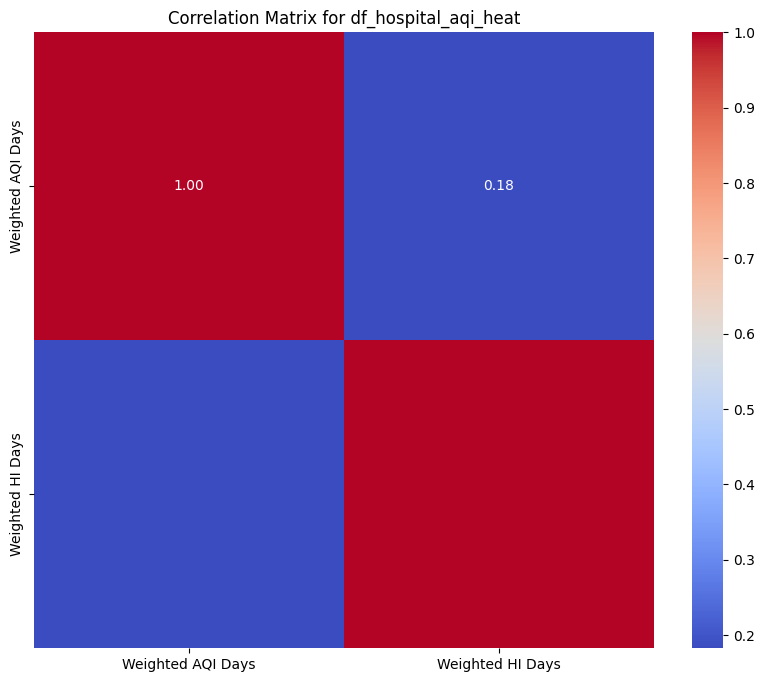

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix
correlation_matrix = df_hospital_aqi_heat.drop(["VisitRate"], axis=1).corr()

# Display the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", cbar=True)
plt.title("Correlation Matrix for df_hospital_aqi_heat")
plt.show()

In [ ]:
# make daily aqi df function
def make_aqi_daily(csv_name):
    df_daily = pd.read_csv(csv_name)
    df_daily['Date'] = pd.to_datetime(df_daily['Date'])
    df_daily['CountyName'] = df_daily['County']
    return df_daily[['CountyName','Date','Daily AQI Value']]
# Make daily AQI dataframes for each year
df_aqi_daily_2015 = make_aqi_daily('air_quality_2015.csv')
df_aqi_daily_2016 = make_aqi_daily('air_quality_2016.csv')
df_aqi_daily_2017 = make_aqi_daily('air_quality_2017.csv')
df_aqi_daily_2018 = make_aqi_daily('air_quality_2018.csv')
df_aqi_daily_2019 = make_aqi_daily('air_quality_2019.csv')
# Combine all years into one dataframe
df_aqi_daily_all = pd.concat([df_aqi_daily_2015, df_aqi_daily_2016, df_aqi_daily_2017, df_aqi_daily_2018, df_aqi_daily_2019], axis=0)
df_aqi_daily_all.head

# drop unique counties for aqi dataframe
unique_counties_aqi = ['Calaveras', 'Glenn','Lake','Madera','Mariposa','Trinity','Nevada','Merced','Mono']
index_names = df_aqi_daily_all[ df_aqi_daily_all['CountyName'] == any(unique_counties_aqi)].index 
  
# drop these row indexes 
# from dataFrame 
df_aqi_daily_all.drop(df_aqi_daily_all[ df_aqi_daily_all['CountyName'] == 'Calaveras'].index, inplace = True) 
df_aqi_daily_all.drop(df_aqi_daily_all[ df_aqi_daily_all['CountyName'] == 'Glenn'].index, inplace = True) 
df_aqi_daily_all.drop(df_aqi_daily_all[ df_aqi_daily_all['CountyName'] == 'Lake'].index, inplace = True) 
df_aqi_daily_all.drop(df_aqi_daily_all[ df_aqi_daily_all['CountyName'] == 'Madera'].index, inplace = True) 
df_aqi_daily_all.drop(df_aqi_daily_all[ df_aqi_daily_all['CountyName'] == 'Mariposa'].index, inplace = True) 
df_aqi_daily_all.drop(df_aqi_daily_all[ df_aqi_daily_all['CountyName'] == 'Trinity'].index, inplace = True) 
df_aqi_daily_all.drop(df_aqi_daily_all[ df_aqi_daily_all['CountyName'] == 'Nevada'].index, inplace = True) 
df_aqi_daily_all.drop(df_aqi_daily_all[ df_aqi_daily_all['CountyName'] == 'Merced'].index, inplace = True) 
df_aqi_daily_all.drop(df_aqi_daily_all[ df_aqi_daily_all['CountyName'] == 'Mono'].index, inplace = True) 
print("length of aqi df:",len(df_aqi_daily_all))

df_meteor.drop(df_meteor[ df_meteor['CountyName'] == 'Modoc' ].index , inplace = True) 
df_meteor.drop(df_meteor[ df_meteor['CountyName'] == 'Amador' ].index , inplace = True) 
print('length of heat df:',len(df_meteor))



length of aqi df: 204238
length of heat df: 73467


In [ ]:
# Merge daily AQI and meteorology dataframes
df_meteor['Date'] = df_meteor['Date'].astype(str)
df_aqi_daily_all['Date'] = df_aqi_daily_all['Date'].astype(str)
df_aqi_heat_daily = df_aqi_daily_all.merge(df_meteor[["CountyName", "Date", "Heat Index"]], on=['CountyName','Date'],how='outer')
for i in range(len(df_aqi_heat_daily)):
    if df_aqi_heat_daily.get_value(i,'Daily AQI Value') >= 100 and df_aqi_heat_daily.get_value(i,'Heat Index') >= 80:
        df_aqi_heat_daily[i,'Over Thresholds'] = 1

KeyError: 'Date'

In [ ]:
range(len(df_aqi_heat_daily))

range(0, 218972)

In [ ]:
df_meteor.head

# drop unique counties for meteorology dataframe
unique_counties_met = ['Modoc','Amador']
index_names_m = df_meteor[ df_meteor['CountyName'] == 'Amador' ].index 
  
# drop these row indexes 
# from dataFrame 
df_meteor.drop(index_names_m, inplace = True) 
print("length of meteor df:",len(df_meteor))
print(pd.unique(df_meteor['CountyName'])) # drop modoc, amador



#print(pd.unique(df_aqi_daily_all['CountyName'])) # contains 9 extra counties: calaveras, glenn, lake, madera, mariposa, trinity, nevada, merced, mono
#print(pd.unique(df_hospital_aqi_heat['CountyName'])) # no alpine, humboldt, del norte, or plumas

<bound method NDFrame.head of       CountyName        Date  Avg Max Air Temp (F)  Avg Max Rel Hum (%)  \
0         Fresno  2015-01-01             53.228571            93.285714   
1         Fresno  2015-01-02             52.628571            90.714286   
2         Fresno  2015-01-03             55.571429            91.142857   
3         Fresno  2015-01-04             56.214286            91.857143   
4         Fresno  2015-01-05             60.271429            92.000000   
...          ...         ...                   ...                  ...   
75288     Solano  2019-12-27             62.400000            86.000000   
75289     Solano  2019-12-28             59.350000            96.500000   
75290     Solano  2019-12-29             50.850000           100.000000   
75291     Solano  2019-12-30             65.800000            98.500000   
75292     Solano  2019-12-31             60.350000            98.500000   

       Heat Index  Year  
0       52.932214  2015  
1       52.241786

In [ ]:
from statsmodels.stats.diagnostic import het_breuschpagan

# insurance
bp_test = het_breuschpagan(results_more_insurance.resid, x2_more_insurance)
# bp_test_labels = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
# for name, value in zip(bp_test_labels, bp_test):
#     print(f"{name}: {value}")
if bp_test[1] > 0.05: 
    print("homoskedasticity present for MORE INSURANCE")
else: 
    print("heteroskedasticity present for MORE INSURANCE")

bp_test = het_breuschpagan(results_less_insurance.resid, x2_less_insurance)
if bp_test[1] > 0.01: 
    print("homoskedasticity present for LESS INSURANCE")
else: 
    print("heteroskedasticity present for LESS INSURANCE")
    bp_test_labels = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
    for name, value in zip(bp_test_labels, bp_test):
        print(f"{name}: {value}")

# ethnicity
bp_test = het_breuschpagan(results_not_hisp.resid, x2_not_hisp)
if bp_test[1] > 0.05: 
    print("homoskedasticity present for NOT HISPANIC")
else: 
    print("heteroskedasticity present for NOT HISPANIC")

bp_test = het_breuschpagan(results_hisp.resid, x2_hisp)
if bp_test[1] > 0.05: 
    print("homoskedasticity present for HISPANIC")
else: 
    print("heteroskedasticity present for HISPANIC")

# poverty
bp_test = het_breuschpagan(results_no_pov.resid, x2_no_pov)
if bp_test[1] > 0.01: 
    print("homoskedasticity present for NO POV")
else: 
    print("heteroskedasticity present for NO POV")
    bp_test_labels = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
    for name, value in zip(bp_test_labels, bp_test):
        print(f"{name}: {value}")


bp_test = het_breuschpagan(results_pov.resid, x2_pov)
if bp_test[1] > 0.05: 
    print("homoskedasticity present for POV")
else: 
    print("heteroskedasticity present for POV")

homoskedasticity present for MORE INSURANCE
homoskedasticity present for LESS INSURANCE
homoskedasticity present for NOT HISPANIC
homoskedasticity present for HISPANIC
homoskedasticity present for NO POV
homoskedasticity present for POV


In [ ]:
# Shapiro Wilks Test
from scipy.stats import shapiro

print("MORE INSURANCE")
stat, p_value = shapiro(results_more_insurance.resid)
# print("Shapiro-Wilk Test Statistic:", stat)
# print("p-value:", p_value)
if p_value > 0.01:
    print("Residuals appear to be normally distributed (fail to reject H0).")
else:
    print("Residuals do not appear to be normally distributed (reject H0).")

print("LESS INSURANCE")
stat, p_value = shapiro(results_less_insurance.resid)
if p_value > 0.01:
    print("Residuals appear to be normally distributed (fail to reject H0).")
else:
    print("Residuals do not appear to be normally distributed (reject H0).")

print("NOT HISPANIC")
stat, p_value = shapiro(results_not_hisp.resid)
if p_value > 0.01:
    print("Residuals appear to be normally distributed (fail to reject H0).")
else:
    print("Residuals do not appear to be normally distributed (reject H0).")

print("HISPANIC")
stat, p_value = shapiro(results_hisp.resid)
if p_value > 0.01:
    print("Residuals appear to be normally distributed (fail to reject H0).")
else:
    print("Residuals do not appear to be normally distributed (reject H0).")

print("NO POVERTY")
stat, p_value = shapiro(results_no_pov.resid)
if p_value > 0.01:
    print("Residuals appear to be normally distributed (fail to reject H0).")
else:
    print("Residuals do not appear to be normally distributed (reject H0).")

print("POVERTY")
stat, p_value = shapiro(results_pov.resid)
if p_value > 0.01:
    print("Residuals appear to be normally distributed (fail to reject H0).")
else:
    print("Residuals do not appear to be normally distributed (reject H0).")

MORE INSURANCE
Residuals do not appear to be normally distributed (reject H0).
LESS INSURANCE
Residuals do not appear to be normally distributed (reject H0).
NOT HISPANIC
Residuals appear to be normally distributed (fail to reject H0).
HISPANIC
Residuals appear to be normally distributed (fail to reject H0).
NO POVERTY
Residuals do not appear to be normally distributed (reject H0).
POVERTY
Residuals appear to be normally distributed (fail to reject H0).
